In [70]:
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

src_path = os.path.join(os.getcwd(), "..")
sys.path.append(src_path)

from src.distance_calculation import CoordinateCounterTree, vectorized_distance, haversine_distance
from src.map_manager import load_europe_map

eu_countries_plus_uk = {
    "Austria": "AUT",
    "Belgium": "BEL",
    "Bulgaria": "BGR",
    "Croatia": "HRV",
    "Cyprus": "CYP",
    "Czech Republic": "CZE",
    "Denmark": "DNK",
    "Estonia": "EST",
    "Finland": "FIN",
    "France": "FRA",
    "Germany": "DEU",
    "Greece": "GRC",
    "Hungary": "HUN",
    "Ireland": "IRL",
    "Italy": "ITA",
    "Latvia": "LVA",
    "Lithuania": "LTU",
    "Luxembourg": "LUX",
    "Malta": "MLT",
    "Netherlands": "NLD",
    "Poland": "POL",
    "Portugal": "PRT",
    "Romania": "ROU",
    "Slovakia": "SVK",
    "Slovenia": "SVN",
    "Spain": "ESP",
    "Sweden": "SWE",
    "United Kingdom": "GBR"
}

In [71]:
file_path = os.path.join("..", "data", "raw_data", "2019_AIS.csv")
emissions_df = (pd.read_csv(file_path)
                  .rename(columns = {"IMO": "shipID", "E_CO2_kg" : "co2"})
                  )
emissions_df = (emissions_df.assign(indexID = range(len(emissions_df)))
                            .sort_values(["shipID", "TIME"], ascending=True)
                            .reset_index(drop=True)
                            )
emissions_df["chronologicOrder"] = (emissions_df.groupby("shipID")["indexID"]
                                                 .transform(lambda x : range(len(x)))
                                                 )
emissions_df.head()

shipID                 TIME       SOG  LONGITUDE   LATITUDE        co2  \
0  9619907  2019-01-01 00:00:00  0.000000   114.2725  22.568383  1517.1408   
1  9619907  2019-01-01 01:00:00  0.104613   114.2725  22.568383  1517.1408   
2  9619907  2019-01-01 02:00:00  0.104613   114.2725  22.568383  1517.1408   
3  9619907  2019-01-01 03:00:00  0.104613   114.2725  22.568383  1517.1408   
4  9619907  2019-01-01 04:00:00  0.104613   114.2725  22.568383  1517.1408   

   indexID  chronologicOrder  
0   285040                 0  
1    27082                 1  
2   735487                 2  
3   768607                 3  
4   543000                 4

In [72]:
emissions_df["TIME"] = pd.to_datetime(emissions_df["TIME"])
agg_dict = {"LATITUDE" : "last", "LONGITUDE" : "last", "SOG" : "mean", "co2": "mean"}
emissions_daily_df = ((emissions_df.loc[emissions_df["shipID"] == ship]
                        .set_index("TIME")
                        .resample("D")
                        .agg(agg_dict)
                        .assign(shipID=ship)
                        )
                     for ship in emissions_df.shipID.unique()
                     )
emissions_daily_df = pd.concat(emissions_daily_df, axis=0).sort_index()
emissions_daily_df.head()

LATITUDE   LONGITUDE        SOG           co2   shipID
TIME                                                               
2019-01-01  22.568383  114.272500   0.100254   1517.140800  9619907
2019-01-01  34.879257  128.704043   0.000000      0.000000  9780483
2019-01-01  37.727556    7.966974  15.316468  13360.618965  9619933
2019-01-01  53.598333    8.515000   3.381237   3700.306380  9632155
2019-01-01  34.300037  133.771320   0.100000      0.000000  9832717

In [73]:
model_df = (emissions_daily_df.copy()
                              .assign(co2 = emissions_daily_df["co2"] / 1000,
                                    SOG = emissions_daily_df["SOG"] - emissions_daily_df["SOG"].mean(),
                                    SOG_squared = lambda x : x["SOG"]**2
                                    )
                              )
model = smf.ols("co2~SOG+SOG_squared", data = model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.286e+05
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:28:22   Log-Likelihood:                -93375.
No. Observations:               36500   AIC:                         1.868e+05
Df Residuals:                   36497   BIC:                         1.868e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7118      0.032    211.930      0.000       6.650       6.774
SOG             1.1213      0.002    507.100      0.000       1.117       1.126
SOG_squared     0.0593      0.000    127.270      0.000       0.058       0.060
==============================================================================
Omnibus:                     6990.696   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46884.198
Skew:                           0.756   Prob(JB):                         0.00
Kurtosis:                       8.342   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
lr = LinearRegression()
lr.fit(emissions_daily_df[["SOG"]].values, emissions_daily_df["co2"].values / 1000)
coef, intercept = lr.coef_, lr.intercept_
x_points = np.linspace(0, 25, 10)
y_points = x_points * coef + intercept

fig = px.scatter(emissions_daily_df,
           "SOG",
           emissions_daily_df["co2"].values / 1000,
           title = "Mean emission in function of speed",
           color = emissions_daily_df["co2"].values / 1000,
           color_continuous_scale="viridis")
fig.update_layout(xaxis_title = "Speed over ground km/h",
                  yaxis_title = "CO2 emissions (tonnes)")

In [75]:
emissions_df["TIME"] = pd.to_datetime(emissions_df["TIME"])
agg_dict = {"LATITUDE" : "last", "LONGITUDE" : "last", "SOG" : "mean", "co2": "sum"}
emissions_daily_df = ((emissions_df.loc[emissions_df["shipID"] == ship]
                        .set_index("TIME")
                        .resample("D")
                        .agg(agg_dict)
                        .assign(shipID=ship)
                        )
                     for ship in emissions_df["shipID"].unique()
                     )
emissions_daily_df = pd.concat(emissions_daily_df, axis=0).sort_index()

distance      co2_tonne  CO2_dist
shipID                                         
9780445  153735.691616  147382.063139  0.958672
9778791  143272.722980  136910.603970  0.955594
9780469  143749.713428  137200.968557  0.954443
9780457  138305.054859  131606.784002  0.951569
9778820  156252.561675  144622.402788  0.925568
...                ...            ...       ...
9773210  151615.677424   40258.450898  0.265530
9839466  152033.151922   36951.741637  0.243051
9839296  143345.695638   22955.252505  0.160139
9832729  154134.515322   17379.319911  0.112754
9839301  159333.494849   15169.990743  0.095209

[100 rows x 3 columns]

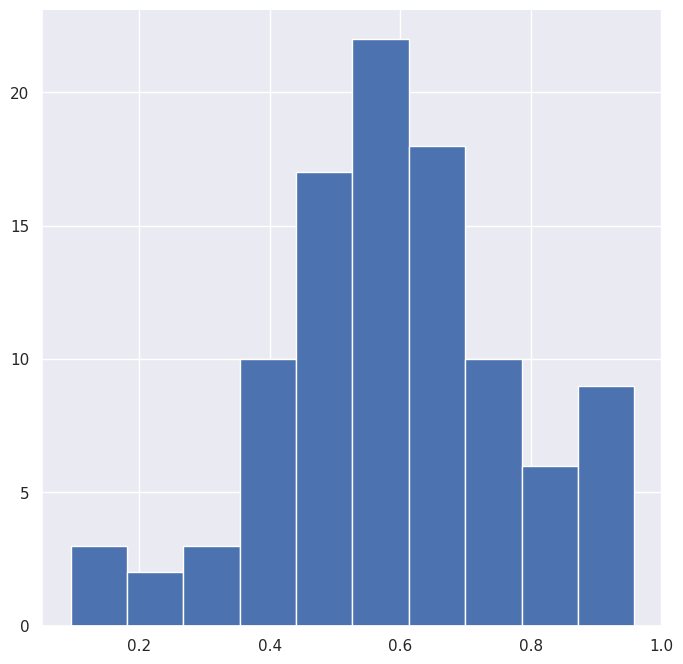

In [77]:
res = []
for ship in emissions_daily_df.shipID.unique():
    tmp_ = emissions_daily_df.loc[emissions_daily_df["shipID"] == ship,["LATITUDE", "LONGITUDE"]].reset_index(drop=True)
    coords = [tuple(tmp_.iloc[0].values)]
    for row in tmp_.itertuples():
        d = haversine_distance((row[1], row[2]), coords[-1])
        res.append(d)
        coords.append((row[1], row[2]))
res = np.array(res)
emissions_daily_df["distance"] = np.where(res > 1200, 1200, res)
emissions_daily_df["co2_tonne"] = emissions_daily_df["co2"] / 1000
test = (emissions_daily_df.groupby("shipID")[["distance", "co2_tonne"]]
                   .sum()
                   .assign(CO2_dist = lambda x : x["co2_tonne"] / x["distance"])
                   .sort_values("CO2_dist", ascending=False)
                   )
plt.hist(test.CO2_dist);
test

In [ ]:
model_df = (emissions_daily_df.copy()
                              .assign(co2 = emissions_daily_df["co2"] / 1000,
                                    SOG = emissions_daily_df["SOG"] - emissions_daily_df["SOG"].mean(),
                                    SOG_squared = lambda x : x["SOG"]**2
                                    )
                              )
model = smf.ols("co2~SOG+SOG_squared", data = model_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.286e+05
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:47:16   Log-Likelihood:                -93375.
No. Observations:               36500   AIC:                         1.868e+05
Df Residuals:                   36497   BIC:                         1.868e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7118      0.032    211.930      0.000       6.650       6.774
SOG             1.1213      0.002    507.100      0.000       1.117       1.126
SOG_squared     0.0593      0.000    127.270      0.000       0.058       0.060
==============================================================================
Omnibus:                     6990.696   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46884.198
Skew:                           0.756   Prob(JB):                         0.00
Kurtosis:                       8.342   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
emissions_df.describe().T.iloc[2:,:]

count         mean        min        25%          50%  \
SOG               876000.0     9.991397        0.0        0.0         13.0   
LONGITUDE         876000.0    72.263464 -179.83936  18.711065    87.466118   
LATITUDE          876000.0    29.167603 -52.295492  16.239959    31.988333   
co2               876000.0  10163.32049        0.0   1548.498  7862.689181   
indexID           876000.0     437999.5        0.0  218999.75     437999.5   
chronologicOrder  876000.0       4379.5        0.0    2189.75       4379.5   

                           75%           max            std  
SOG                       17.8         33.45       8.359293  
LONGITUDE           121.070237    179.837897      50.433971  
LATITUDE                  37.3     85.301673      15.221569  
co2               17597.390615  43603.002778     9581.54071  
indexID              656999.25      875999.0  252879.562243  
chronologicOrder       6569.25        8759.0    2528.795606

In [10]:
file_path = os.path.join("..", "data", "raw_data", "PORTS.xlsx")
ports_df = (pd.read_excel(file_path)
            .rename(columns = {"PORT_NAME":"port", "CNTR_CODE3" : "ccode"})
                  )
ports_df.head()

port ccode  LONGITUDE   LATITUDE
0     PALAMOS   ESP   3.130501  41.844646
1   CHERBOURG   FRA  -1.617801  49.649769
2      DUBLIN   IRL  -6.212487  53.343665
3  STRASBOURG   FRA   7.790219  48.577101
4    PIOMBINO   ITA  10.545598  42.936886

In [11]:
(ports_df.loc[lambda x : x.ccode.isin(eu_countries_plus_uk.values()),"ccode"]
         .value_counts()
         .iloc[:10,]
         )

ccode
GBR    512
GRC    367
DNK    217
SWE    209
ITA    201
DEU    167
FRA    152
HRV    142
ESP    135
NLD    125
Name: count, dtype: int64

In [12]:
DISTANCE = 10
MAX_SPEED = 100

emissions_at_port = emissions_daily_df.loc[emissions_daily_df["SOG"] <= MAX_SPEED,:]
lat = emissions_at_port["LATITUDE"].values[:,None]
lon = emissions_at_port["LONGITUDE"].values[:,None]

cct = CoordinateCounterTree.from_data_points(lat,lon)
count = cct.calculate_points_within_distance(ports_df.loc[:,["LATITUDE", "LONGITUDE"]].values, distance_km=DISTANCE)
ports_list = list(count)

In [13]:
emissions_array = emissions_at_port["co2"].values
ports_df["visits"] = [len(port) for port in ports_list]
ports_df["emissions"] = [np.sum(emissions_array[port]) if len(port) > 0 else 0 for port in ports_list]
ports_eu = (ports_df.copy()
                    .loc[lambda x : (x.ccode.isin(eu_countries_plus_uk.values())) & (x.visits > 0)]
                    .sort_values("visits", ascending=True)
                    .assign(emissions_per_visit = lambda x : x["emissions"] / x["visits"])
                    )
ports_eu

port ccode  LONGITUDE   LATITUDE  \
5902                                  ANHOLT HAVN   DNK  11.506890  56.715556   
7522                            RADE DE CHERBOURG   FRA  -1.633333  49.650000   
5849                        STIGNAESVAERKETS HAVN   DNK  11.250100  55.221334   
3843  FOLEGANDROS KYKLADES (FOLEGANDROS KIKLADON)   GRC  24.917465  36.626389   
499                                       MESSINA   ITA  15.564169  38.193227   
...                                           ...   ...        ...        ...   
8006               BREMERHAVEN CONTAINER TERMINAL   DEU   8.534580  53.584301   
20                                        HAMBURG   DEU   9.964576  53.527793   
203                                  FINKENWERDER   DEU   9.866782  53.538054   
778                                     EUROPOORT   NLD   4.134375  51.938728   
692                              HOEK VAN HOLLAND   NLD   4.116585  51.982031   

      visits     emissions  emissions_per_visit  
5902       1  1.939499e+05        193949.933561  
7522       1  4.206935e+05        420693.489450  
5849       1  3.206694e+05        320669.413644  
3843       1  3.847031e+05        384703.067690  
499        1  5.546958e+04         55469.578084  
...      ...           ...                  ...  
8006     397  3.446728e+07         86819.335560  
20       416  2.592399e+07         62317.291670  
203      420  2.607475e+07         62082.744618  
778      857  6.339050e+07         73967.906580  
692      865  6.506341e+07         75217.814929  

[133 rows x 7 columns]

In [14]:
agg_dict = {"visits":"sum", "emissions":"sum"}
(ports_eu.groupby("ccode")
         .agg(agg_dict)
         .assign(emissions = lambda x : x["emissions"] / 1000,
                 emissions_per_visit = lambda x : x["emissions"] / x["visits"],
                 share_of_emissions = lambda x : 100 * x["emissions"] / sum(x["emissions"]),
                 share_of_visits = lambda x : 100 * x["visits"] / sum(x["visits"]),
                 )
         .sort_values("visits", ascending = False)
         .iloc[:5,:]
         .transpose()
         .applymap(lambda x : round(x))
         )

ccode                   DEU     NLD     GRC    GBR    POL
visits                 2773    1830    1431   1389    751
emissions            215242  141757  120593  98541  54892
emissions_per_visit      78      77      84     71     73
share_of_emissions       28      18      16     13      7
share_of_visits          29      19      15     14      8

/tmp/ipykernel_12926/2682800541.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



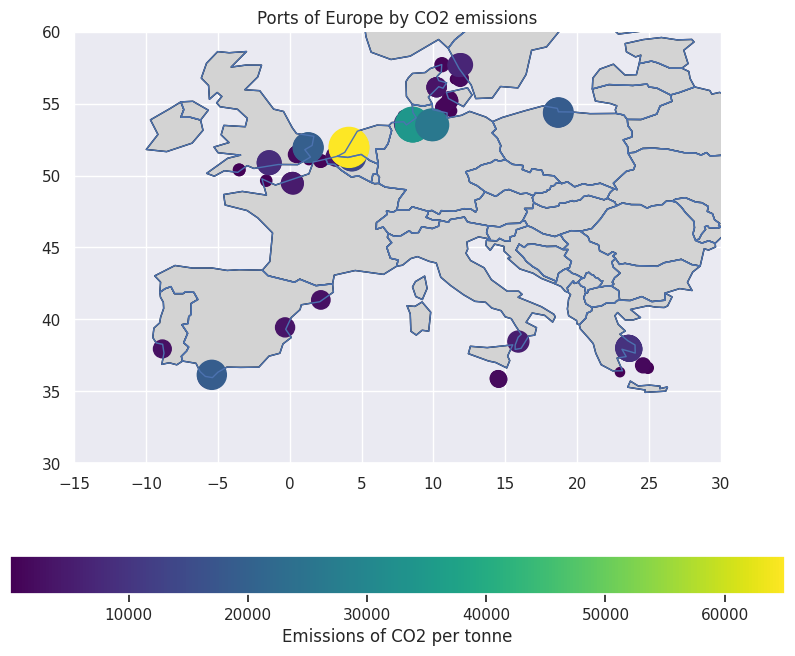

In [15]:
MARKER_SIZE = 25
PORT_N = 100
# Load the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ports_eu = (ports_eu.iloc[:,:]
                    .assign(emissions = lambda x : x["emissions"] / 1000)
                    )
# Extract Europe data
europe = (world.loc[world['continent'] == 'Europe']
               .iloc[1:,:]
               )
port_geometry = [Point(xy) for xy in zip(ports_eu['LONGITUDE'], ports_eu['LATITUDE'])]
port_gdf = gpd.GeoDataFrame(ports_eu[["port", "visits", "emissions"]], geometry=port_geometry)

# Plot the map
MARKER_SIZE = (port_gdf["emissions"].values * 10) ** 0.5
fig, ax = plt.subplots(figsize=(10, 8))
europe.boundary.plot(ax=ax, linewidth=1)
europe.plot(ax=ax,
            color='lightgray',
            edgecolor='black'
            )
port_gdf.plot(ax=ax,
              marker='o',
              column="emissions",
              cmap='viridis',
              markersize=MARKER_SIZE,
              legend=True,
              legend_kwds={'label': "Emissions of CO2 per tonne",
                      'orientation': "horizontal"
                      }
              )
ax.set_xlim([-15, 30])
ax.set_ylim([30, 60])

ax.set_title('Ports of Europe by CO2 emissions')
plt.show();

In [16]:
coords = list(zip(emissions_daily_df["LONGITUDE"].values, emissions_daily_df["LATITUDE"].values))
co2_ships = emissions_daily_df["co2"].values
squares = load_europe_map([-15, 30], [30, 60], 20, coords, co2_ships)

Finished 0 rows
Finished 10000 rows
Finished 20000 rows
Finished 30000 rows


In [17]:
test = squares.copy().loc[lambda x : x.emissions > 0]

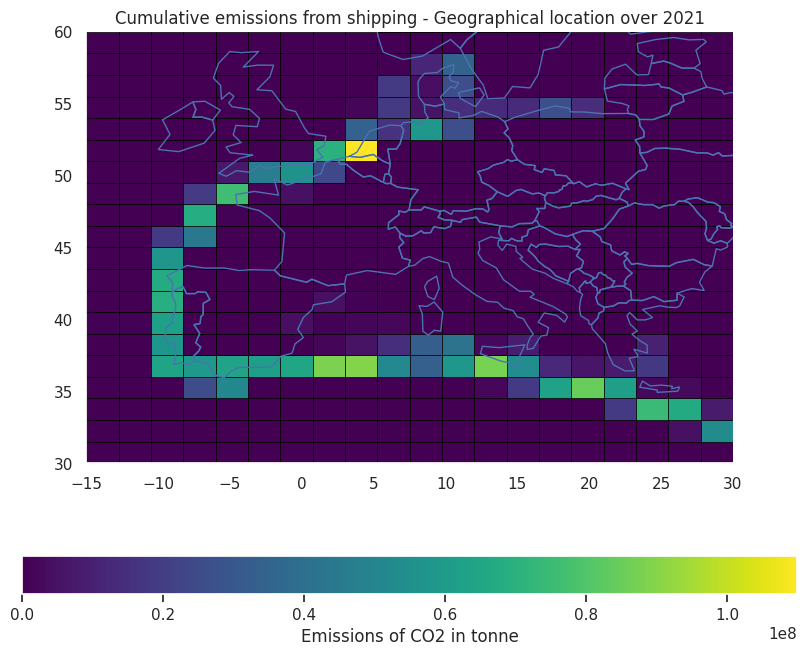

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
europe.boundary.plot(ax=ax, linewidth=1)
europe.plot(ax=ax, color='black', edgecolor='black')

# Plot the grid squares with color based on city count
squares.plot(column='emissions',
             cmap='viridis',
             edgecolor='black',
             linewidth=0.5,
             ax=ax,
             legend=True,
             legend_kwds={'label': "Emissions of CO2 in tonne",
                          'orientation': "horizontal"
                          }
              )
ax.set_xlim([-15, 30])
ax.set_ylim([30, 60])

# Customize the plot (optional)
ax.set_title('Cumulative emissions from shipping - Geographical location over 2021')
plt.show()